# Image Classification with Convolutional Neural Networks

This tutorial explains how image classification with CNNs can be handled in safeds with the `NeuralNetworkClassifier`. The data used contains of multiple drawn shapes and can be found on [kaggle](https://www.kaggle.com/datasets/cactus3/basicshapes/data).

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    All operations on an <code>NeuralNetworkClassifier</code> return a new <code>NeuralNetworkClassifier</code>. The original <code>NeuralNetworkClassifier</code> will not be changed.
  </p>
</div>

## Load data into an `ImageDataset`

1. Load images via files in an `ImageList`. The data is available under `docs/tutorials/data/shapes`. If the `return_filenames` parameter is set to `True`, a list of all filepaths will be returned as well in the same order as the images in the returned `ImageList`.

In [1]:
from safeds.data.image.containers import ImageList

images, filepaths = ImageList.from_files("data/shapes", return_filenames=True)

2. Create a `Column` with the labels of the images:

In [ ]:
import re

from safeds.data.tabular.containers import Column

labels = Column(
    "label", 
    [re.search(r"(.*)[\\/](.*)[\\/](.*)\.", filepath).group(2) for filepath in filepaths],
)

3. Create an `ImageDataset` from the `ImageList` and the `Column` of labels. If the `shuffle` parameter is set to `True`, the `ImageDataset` will be shuffled after each epoch while training a neural network.

In [ ]:
from safeds.data.labeled.containers import ImageDataset

dataset = ImageDataset[Column](images, labels, shuffle=True)

## Create the neural network with a `NeuralNetworkClassifier`

1. Create a list of `Layer` instances for your neural network:

In [ ]:
from safeds.ml.nn.layers import Convolutional2DLayer, FlattenLayer, ForwardLayer, MaxPooling2DLayer

layers = [
    Convolutional2DLayer(output_channel=16, kernel_size=3, padding=1),
    MaxPooling2DLayer(kernel_size=2, stride=2),
    Convolutional2DLayer(output_channel=32, kernel_size=3, padding=1),
    MaxPooling2DLayer(kernel_size=2, stride=2),
    FlattenLayer(),
    ForwardLayer(neuron_count=128),
    ForwardLayer(neuron_count=3),
]

2. Create a `NeuralNetworkClassifier` from an `InputConversion`, the list of `Layer` instances:

In [ ]:
from safeds.ml.nn import NeuralNetworkClassifier
from safeds.ml.nn.converters import InputConversionImageToColumn

cnn = NeuralNetworkClassifier[ImageDataset[Column], ImageList](
    InputConversionImageToColumn(dataset.input_size), 
    layers,
)

## Fit and predict the `NeuralNetworkClassifier`

1. Fit the `NeuralNetworkClassifier`:

In [ ]:
cnn_fitted = cnn.fit(dataset, epoch_size=32, batch_size=16)

2. Predict values from the `NeuralNetworkClassifier`:

In [ ]:
prediction = cnn_fitted.predict(dataset.get_input())

3. Shuffle the prediction to get a random order:

In [ ]:
shuffled_prediction = prediction.shuffle()

4. Display a subset of the input data:

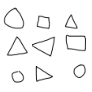

In [ ]:
shuffled_prediction.get_input().remove_image_by_index(list(range(9, len(prediction))))

5. Display the corresponding predicted labels:

In [ ]:
shuffled_prediction.get_output().to_list()[0:9]

['triangles',
 'triangles',
 'triangles',
 'triangles',
 'circles',
 'squares',
 'triangles',
 'squares',
 'squares']